# Metropolis-Hastings Algorythm Example

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Black Sholes


[Black–Scholes–Merton model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) is a mathematical model for the dynamics of the stock market. This model assumes that the price of the underlying asset follows a [Geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion). 

That is, the underlying asset follows the process:

$$ dS(t) = \mu S(t) + \sigma S(t) dW(t) $$


Where:
 - ToDo

or its integral form:

$$ S(t) = S(0) + \int_0^t \mu S(s) ds + \int_0^t \sigma S(s) dW(s) $$




This differential equation has a unique and stable solution:

$$ S(t) = S(0) e^{\mu - \frac{\sigma^2}{2}t + \sigma W(t)} $$

Where:
 - ToDo


In practice, the simulation is not continuous. For two subsequent time points $t_k$ and $t_{k-1}$, the following equation holds:

$$ S(t_k) = S(t_{k-1}) e^{ (\mu - \frac{\sigma^2}{2})(t_k - t_{k-1}) + \sigma (W(t_k) - W(t_{k-1}))} $$


In [3]:
def simulate_Black_Scholes(S0, mu, sigma, T, dt) -> pd.DataFrame:
    
    N = int(T / dt) # number of subintervals of length 1/dt between 0 and max modeling time T
   
    time, delta_t = np.linspace(0, T, num = N+1, retstep = True)
    S = np.exp((mu - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt)* np.random.normal(0, 1 , size= N))
    S = np.hstack([1, S])
    dict = {'Time' : time, 'Stock Price' : S0* S.cumprod(axis=0)}

    stock_price_simulation = pd.DataFrame.from_dict(data = dict)
    stock_price_simulation.set_index('Time', inplace = True)

    return stock_price_simulation

## ESG simulation

Economic Scenario Generators simulate potential future paths of financial indicators such as interest rates, indices and spreads. Most of them do this by assuming that the economy behaves according to a certain stochastic process and present multiple sample paths of this process.

To simulate this, the code bellow generates 1000 scenarios from the Black-Sholes-Merton model. Each scenario simulates 50 years in annual increments.

In [4]:
nScen = 1000
nYear = 50

BSM model takes 2 paramters. The average return $\mu$ and the annual volatility $\sigma$. This example uses the numbers obtained from XXX.

In [5]:
mu = 0.05 #0.106  
sigma = 0.3#0.181 

In [6]:
sample_paths = pd.DataFrame(simulate_Black_Scholes(1, mu, sigma, nYear, 1).values, columns=["Scenario0"])

for iStep in range(1,nScen):
    name = "Scenario"+ str(iStep)
    sample = pd.DataFrame(simulate_Black_Scholes(1, mu, sigma, nYear, 1).values,columns=[name])
    sample_paths = sample_paths.join(sample)

By taking the logarithm of both sides and rearanging the terms, the equation transforms:

$$ ln(S(t_k)) - ln(S(t_{k-1})) = (\mu - \frac{\sigma^2}{2})(t_k - t_{k-1}) + \sigma (W(t_k) - W(t_{k-1})) $$

From the equation above, the distribution of increments can be infered:

$$ ln(S(t_k)) - ln(S(t_{k-1})) \stackrel{d}{\sim} N\big((\mu - \frac{\sigma^2}{2})(t_k - t_{k-1}), \sigma (t_k - t_{k-1})\big) $$

## Log likelihood

The logarithmic increments follow a normal distribution. For convenience, the increment between $t_k$ and $t_{k-1}$ is defined as $x(t_k) = ln(S(t_k)) - ln(S(t_{k-1}))$. The likelihood function of a single increment is:

$$ f_\theta (x(t_k)) = \frac{1}{\sigma \sqrt{2 \pi (t_k - t_{k-1})}} e^{\frac{[x(t_k) - (\mu - \frac{\sigma^2}{2})(t_k - t_{k-1})]^2}{2\sigma^2 (t_k - t_{k-1})}}  $$


The log likelihood for the entire scenario is therefore:

$$ L(\theta) = \sum_{k=1}^n ln(f_\theta(x(t_k)))$$


$$ L(\theta) = \sum_{k=1}^n ln\big(\frac{1}{\sigma \sqrt{2 \pi (t_k - t_{k-1})}} e^{-\frac{[x(t_k) - (\mu - \frac{\sigma^2}{2})(t_k - t_{k-1})]^2}{2\sigma^2 (t_k - t_{k-1})}}\big) = $$

$$= \sum_{k=1}^n -ln(\sigma) -\frac{1}{2}ln(2 \pi (t_k - t_{k-1})) -\frac{[x(t_k) - (\mu - \frac{\sigma^2}{2})(t_k - t_{k-1})]^2}{2\sigma^2 (t_k - t_{k-1})}$$

$$= -n ln(\sigma) -\frac{n}{2}ln(2 \pi)  -\frac{1}{2}\sum_{k=1}^n  ln(t_k - t_{k-1}) -\sum_{k=1}^n\frac{[x(t_k) - (\mu - \frac{\sigma^2}{2})(t_k - t_{k-1})]^2}{2\sigma^2 (t_k - t_{k-1})}$$

## Metropolis Hastings algorithm

To calculate the most likely parameters used to generate the scenarios, the Maximum Likelihood method is normaly used.
This method could be used in this case since the normal distribution has a well known solution. However there are cases where the maximum likelihood estimator does not have a closed solution. 

What is required is to know a function that is able to tell, how much more likely is that the observed data came from one set of parameters as opposed to another set.

A possible solution to this is to use the [Metropolis Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm. To directly quote Wikipedia:

In statistics and statistical physics, the Metropolis–Hastings algorithm is a Markov chain Monte Carlo (MCMC) method for obtaining a sequence of random samples from a probability distribution from which direct sampling is difficult. This sequence can be used to approximate the distribution.

<b> The distribution of interest is the distribution of most likely parameter combinations.</b>  

If the likelihood function is corectly implemented, the distribution should peak at the parameter set, that was set up in the ESG run.


In [7]:
# Prior distribution
prior_mean_1 = 0.2
prior_mean_2 = 0.3
prior_sd_1 = np.sqrt(0.2)
prior_sd_2 = np.sqrt(0.2)

# Proposal distribution
proposal_sd_1 = np.sqrt(0.5)
proposal_sd_2 = np.sqrt(0.2)

data1 = np.log(sample_paths)
data = data1.diff()[1:]

Normal distribution; log likelihood function

In [8]:
def lnorm_lf(mu,sigma,x):
# Log likelihood of a vector from the normal distribution
    n = x.size
    
    out = -n/2 * np.log(2*np.pi)-n*np.log(sigma) -1/(2 * np.power(sigma,2))*np.sum((x-(mu-sigma**2 /2))**2)
    return out


Normal distribution log likelihood function for the prior distribution

In [9]:
def norm_lf(mu,sigma,x):
# Log likelihood of the normal distribution
    n = 1
    #n = x.size
    out = -n/2*np.log(2*np.pi)-n*np.log(sigma)-1/2 * 1/np.power(sigma,2)*(x-mu)**2
    return out

In [10]:
NSteps = 100000
result = np.zeros((NSteps,2))

# Starting position
muhatminus1 = 0.05
sigmahatminus1 = 0.2

# Acceptance vector
u = np.log(np.random.uniform(0,1,NSteps))

for step in range(0,NSteps):
    muhat = np.random.normal(muhatminus1,proposal_sd_1)
    sigmahat = np.random.normal(sigmahatminus1,proposal_sd_2)

    if sigmahat<0:
        sigmahat = -sigmahat

    poslike = lnorm_lf(muhat,sigmahat,data.values)
    neglike = lnorm_lf(muhatminus1,sigmahatminus1,data.values)
        
    poslognorm = poslike + norm_lf(prior_mean_1,prior_sd_1,muhat)+ norm_lf(prior_mean_2,prior_sd_2,sigmahat)
    neglognorm = neglike + norm_lf(prior_mean_1,prior_sd_1,muhatminus1) + norm_lf(prior_mean_2,prior_sd_2,sigmahatminus1)    
    
    alpha = poslognorm - neglognorm
#    u = np.log(np.random.uniform(0,1,1))

    if u[step]>alpha:
        result[step,:] = [muhatminus1, sigmahatminus1]

    else:
        result[step,:] = [muhat, sigmahat]
        muhatminus1 = muhat
        sigmahatminus1 = sigmahat


In [11]:
pdResult = pd.DataFrame(result,columns = ['mu','sigma'])

In [12]:
# Exclude 25% of samples to only include the samples with maximum likelihood and to mitigate  the effect of initial conditions
RealStart = round(nScen*0.25)

(array([ 2059.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 11035., 22658., 11961., 47702.,  4335.]),
 array([0.28658319, 0.28774653, 0.28890987, 0.29007321, 0.29123654,
        0.29239988, 0.29356322, 0.29472656, 0.2958899 , 0.29705324,
        0.29821658, 0.29937991, 0.30054325, 0.30170659, 0.30286993,
        0.30403327]),
 <BarContainer object of 15 artists>)

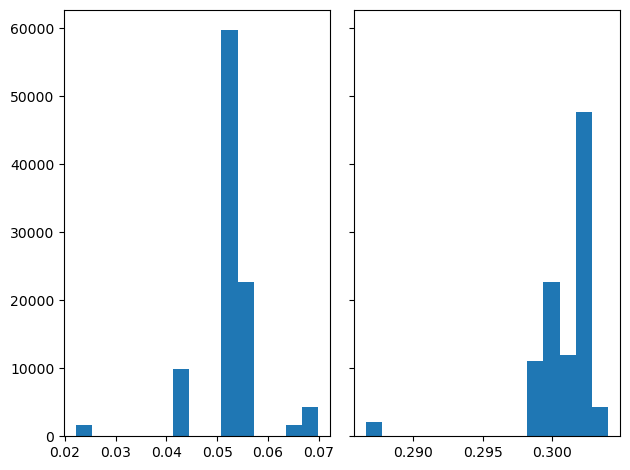

In [13]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(pdResult['mu'][RealStart:], bins=15)
axs[1].hist(pdResult['sigma'][RealStart:], bins=15)

In [14]:
estimatedParam = pdResult[RealStart:].mean(axis=0)

In [15]:
print((mu-estimatedParam["mu"])/mu)

-0.03644812550122625


In [16]:
print((sigma-estimatedParam["sigma"])/sigma)

-0.0038050816106107352
